In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [2]:
sn_data = pd.read_csv("./data.txt", sep="\t", header=0)
sn_data.head()

,supernova name,redshift,distance modulus,distance modulus error,probability
0,1993ah,0.028488,35.346583,0.223906,0.128419
1,1993ag,0.050043,36.682368,0.166829,0.128419
2,1993o,0.052926,36.817691,0.155756,0.128419
3,1993b,0.070086,37.446737,0.158467,0.128419
4,1992bs,0.062668,37.483409,0.156099,0.128419


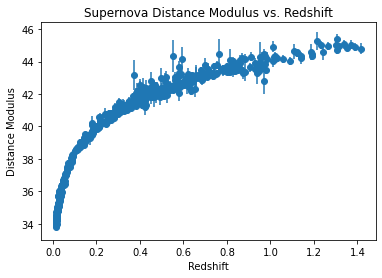

In [3]:
plt.errorbar(sn_data["redshift"], sn_data["distance modulus"], yerr = sn_data["distance modulus error"], xerr=None, fmt='o')
plt.xlabel('Redshift')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift')
plt.show()

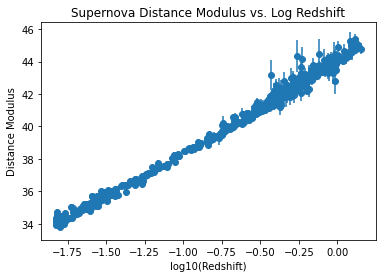

In [4]:
plt.errorbar(np.log10(sn_data["redshift"]), sn_data["distance modulus"], yerr = sn_data["distance modulus error"], xerr=None, fmt='o')
plt.xlabel('log10(Redshift)')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Log Redshift')
plt.show()

In [23]:
small_z_data = sn_data[sn_data["redshift"] < 0.05]
print(len(small_z_data))

140


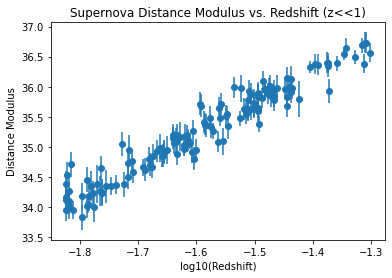

In [24]:
plt.errorbar(np.log10(small_z_data["redshift"]), small_z_data["distance modulus"], yerr = small_z_data["distance modulus error"], xerr=None, fmt='o')
plt.xlabel('log10(Redshift)')
plt.ylabel('Distance Modulus')
plt.title('Supernova Distance Modulus vs. Redshift (z<<1)')
plt.show()

In [25]:
X = np.array(np.log10(small_z_data["redshift"])).reshape(-1, 1)
X = sm.add_constant(X) # add column of 1 for intercept
y = np.array(small_z_data["distance modulus"])

# Weights for weighted least squares
weights = 1 / np.array(small_z_data["distance modulus error"]) ** 2

H0_model = sm.WLS(y, X, weights=weights).fit()
H0_model.params

array([43.34069421,  5.08144534])

In [26]:
H0 = 70 * 10**((H0_model.params[0] - 43.17) / (-5.0))
H0

64.70818180392347